In [1]:
import pandas as pd
import numpy as np
import os

import config as cfg
from utils.yahoo_downloader import YahooDownloader
import utils.helper_functions as hf

# from stockstats import wrap

import matplotlib.pyplot as plt
# import seaborn as sns

#from sklearn.feature_selection import mutual_info_classif

pd.options.mode.chained_assignment = None

In [2]:
folder_path = './db/'
file_name = 'ohlcv.pkl'
file_path = folder_path + file_name

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

if os.path.isfile(file_path):
    df = pd.read_pickle(file_path)

else: # 2 minutes
    df = YahooDownloader(cfg.start_date, cfg.end_date, cfg.tickers).fetch_data()        
    df.to_pickle(file_path)
    df.to_csv(folder_path + 'ohlcv.csv')

df.head()

date       open       high        low      close      volume  \
0  2000-01-03  48.000000  48.000000  47.250000  47.250000     16100.0   
1  2000-01-04   3.830000   3.900000   3.600000   3.680000  10424000.0   
2  2000-01-04   9.820000   9.820000   9.820000   9.820000      4250.0   
3  2000-01-04  34.355453  34.348408  32.248322  32.769817    926084.0   
4  2000-01-04  19.790001  20.590000  19.209999  20.580000   1449856.0   

       tic  day  
0       MT    0  
1   A2A.MI    1  
2  ABCA.PA    1  
3    AC.PA    1  
4    AF.PA    1

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
print(df.dtypes)

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume           float64
tic               object
day                int64
dtype: object


In [5]:
def add_supports_resistances(df: pd.DataFrame) -> pd.DataFrame:
    df['rolling_min'] = hf.get_rolling_min(df['low'], cfg.target_days)
    df['rolling_max'] = hf.get_rolling_max(df['high'], cfg.target_days)
    df['last_close'] = df['close'].shift(1)

    df['pivot'] = hf.get_pivot(df['rolling_max'], df['rolling_min'], df['last_close'])

    df = df.dropna()

    df['support1'] = hf.get_support1(df['pivot'], df['rolling_max'])
    df['support2'] = hf.get_support2(df['pivot'], df['rolling_max'], df['rolling_min'])
    df['resistance1'] = hf.get_resistance1(df['pivot'], df['rolling_min'])
    df['resistance2'] = hf.get_resistance2(df['pivot'], df['rolling_max'], df['rolling_min'])

    return df

In [6]:
def init_support_resistance(df: pd.DataFrame) -> list:
    support = df.iloc[0][cfg.support_column]
    resistance = df.iloc[0][cfg.resistance_column]
    return support, resistance

def update_support_resistance(row_df: pd.DataFrame) -> list:
    support = row_df.__getattribute__(cfg.support_column)
    resistance = row_df.__getattribute__(cfg.resistance_column)
    return support, resistance

def get_profit(df: pd.DataFrame) -> list:
    profits = []
    profit = 1
    buy_price = 0
    bought_days = 0
    is_bought = False
    left_security_days = cfg.fall_security_days

    support, resistance = init_support_resistance(df)

    last_index = len(df) - 1

    for index, row in enumerate(df.itertuples()):
        last_close = row.last_close
        open = row.open

        if left_security_days > 0:
            left_security_days -= 1
        else:
            if is_bought and last_close < buy_price * cfg.support_sell_coef:
                is_bought = False
                sell_price = open
                profit *= (sell_price / buy_price) * cfg.fee_coef
                left_security_days = cfg.fall_security_days
                # print(f'{row.tic} - {row.date}: sold at {sell_price}, operation profit {(sell_price / buy_price) * cfg.fee_coef}')
            elif is_bought and last_close > resistance:
                is_bought = False
                sell_price = open
                profit *= (sell_price / buy_price) * cfg.fee_coef
                # print(f'{row.tic} - {row.date}: sold at {sell_price}, operation profit {(sell_price / buy_price) * cfg.fee_coef}')
            # elif (not is_bought and last_close < support) or index == last_index:
            elif (not is_bought and (last_close < support or
                                    last_close > resistance * cfg.resistance_buy_coef)) or index == last_index:
                is_bought = True
                buy_price = open
                profit *= cfg.fee_coef
                # print(f'{row.tic} - {row.date}: bought at {buy_price}')

        # if (last_close > resistance or last_close < support):
        #     support, resistance = update_support_resistance(row)

        support, resistance = update_support_resistance(row)

        if is_bought:
            bought_days += 1
        
        profits.append({'date': row.date, 'profit': profit})
        
    close_df = df[['date', 'close']]
    close_df['close'] = close_df['close'].div(close_df['close'].iloc[0])
    profit_df = pd.DataFrame(profits)
    graph_df = pd.merge(close_df, profit_df, on='date')

    return profit - 1, bought_days, graph_df

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


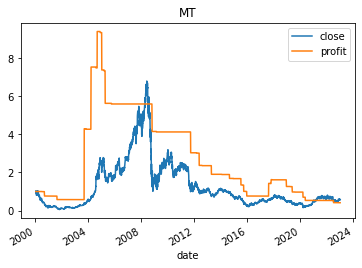

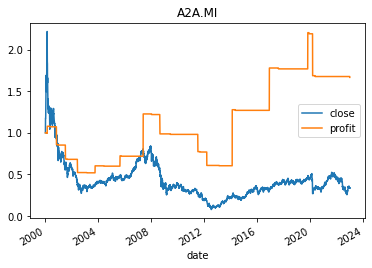

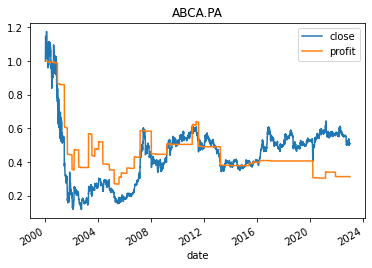

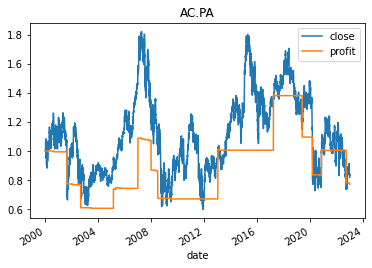

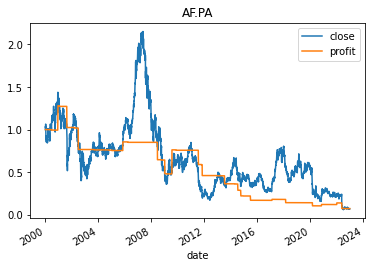

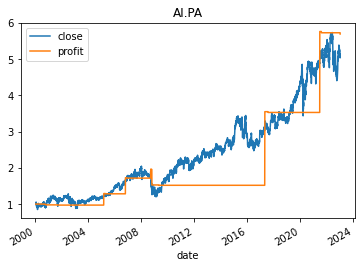

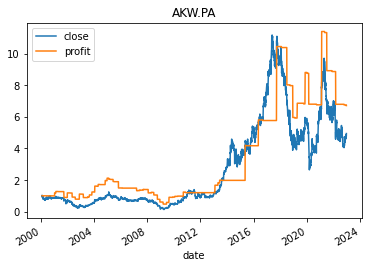

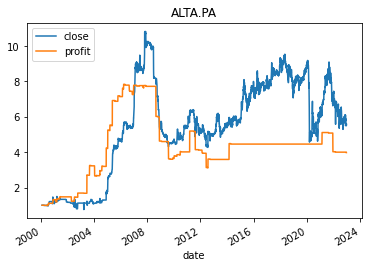

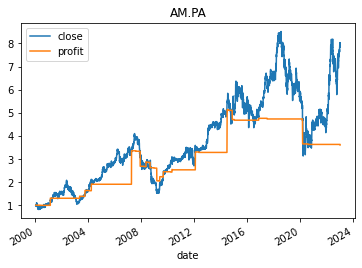

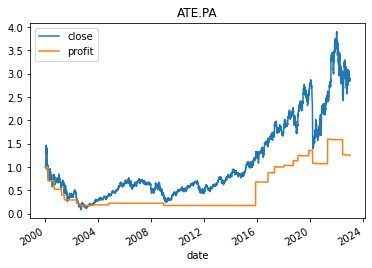

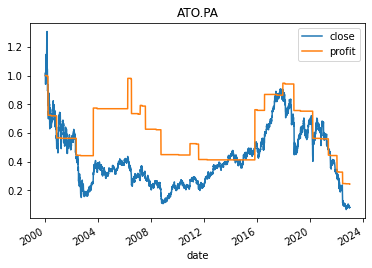

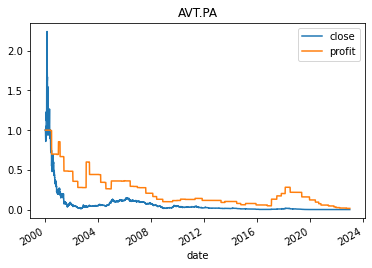

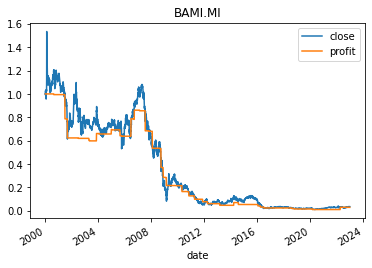

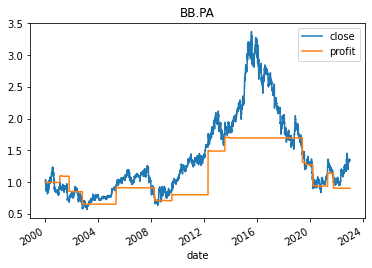

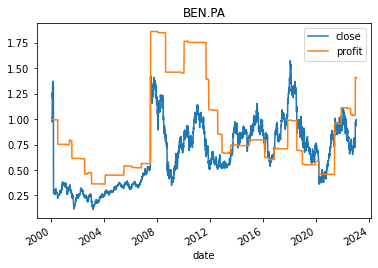

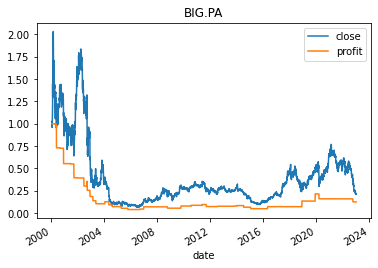

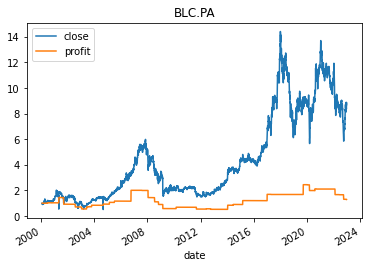

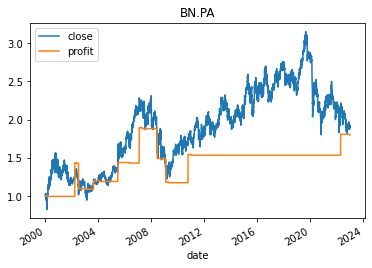

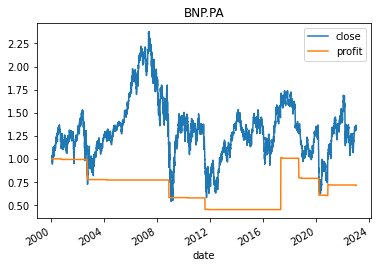

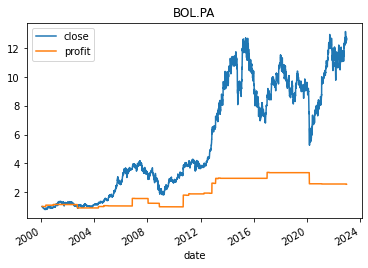

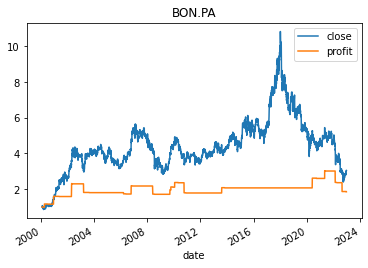

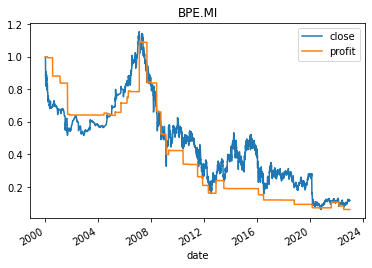

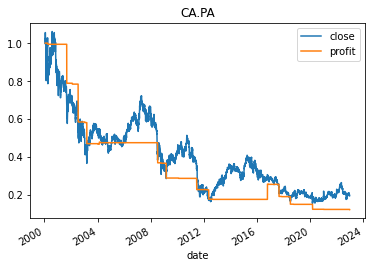

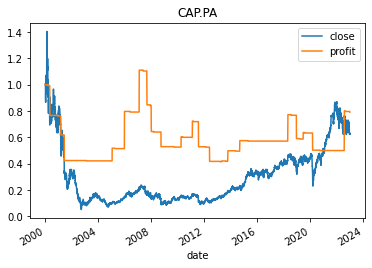

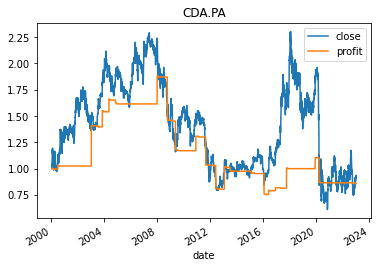

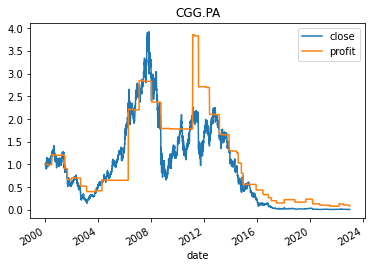

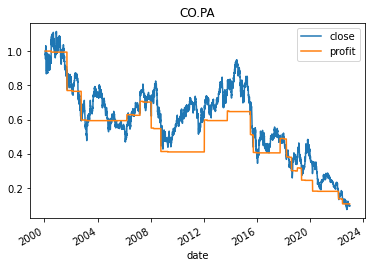

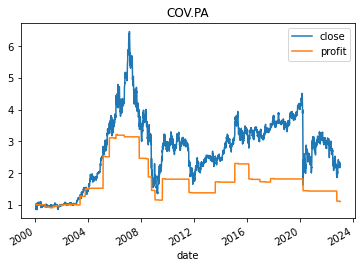

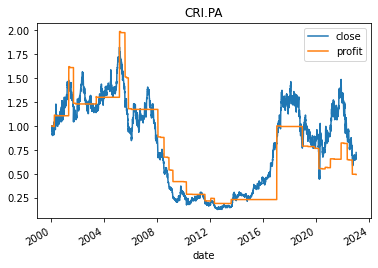

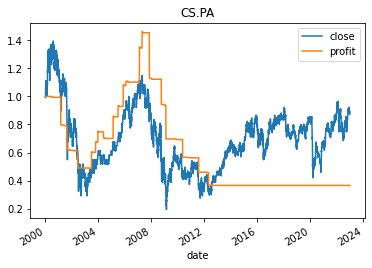

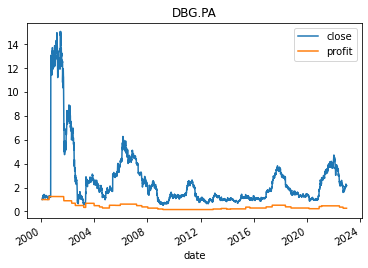

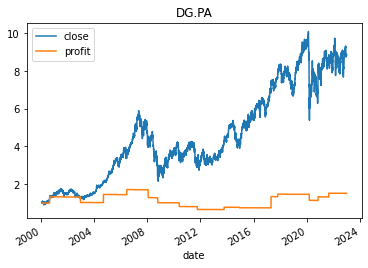

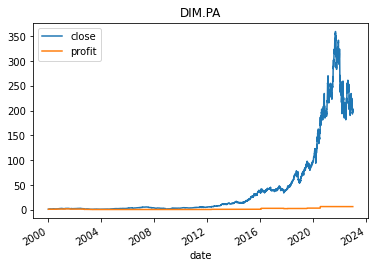

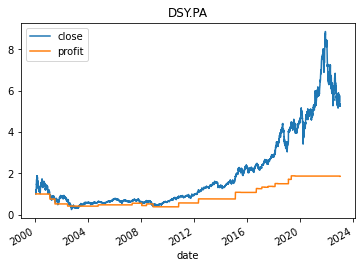

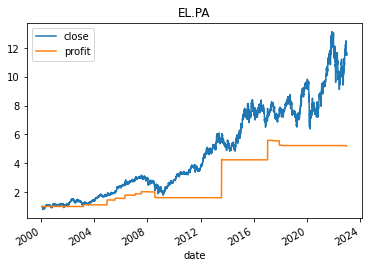

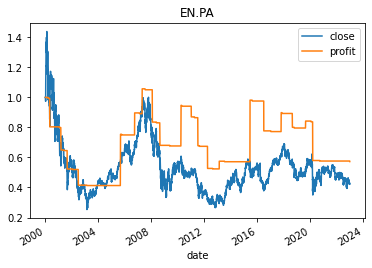

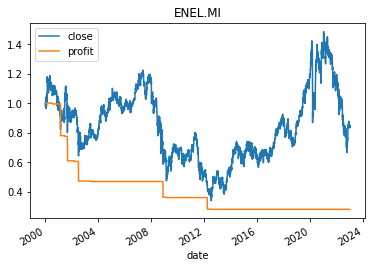

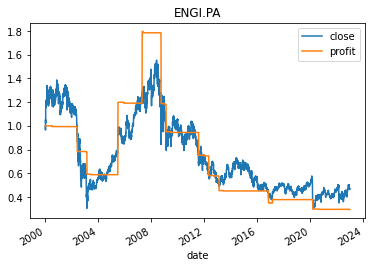

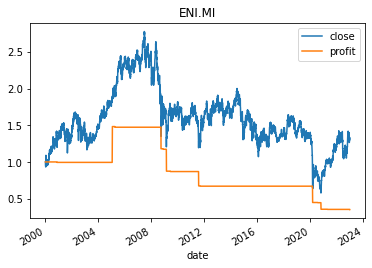

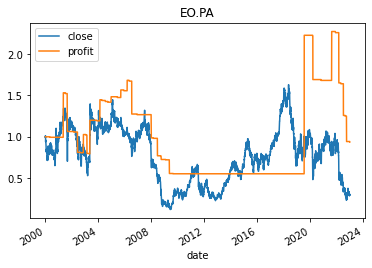

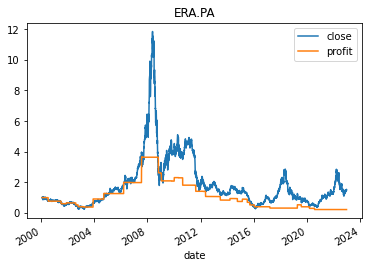

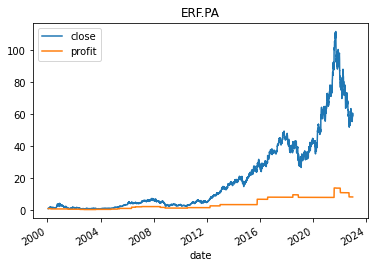

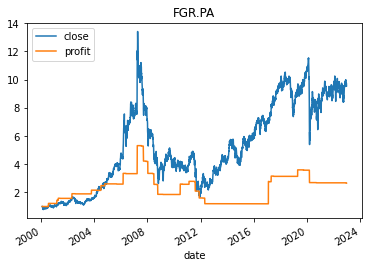

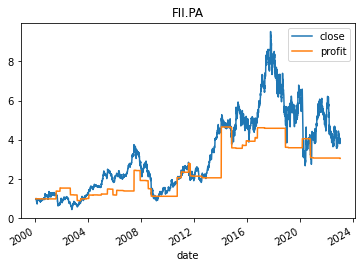

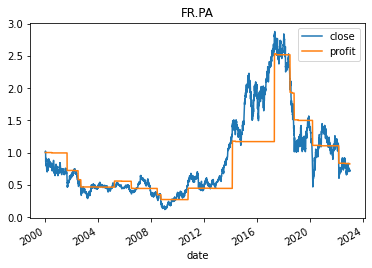

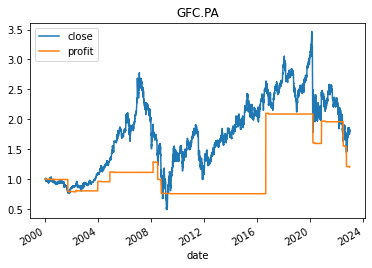

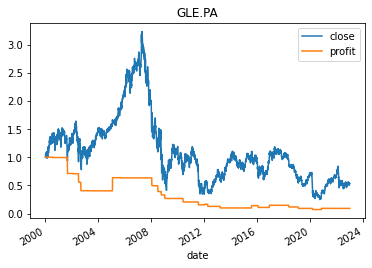

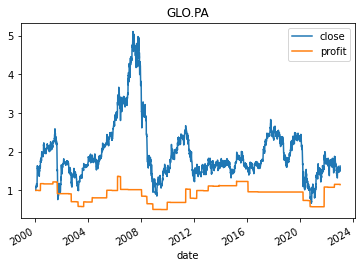

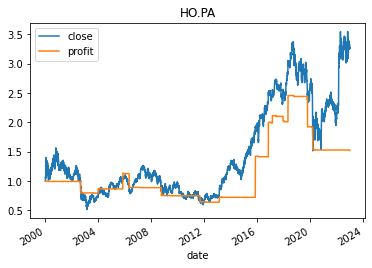

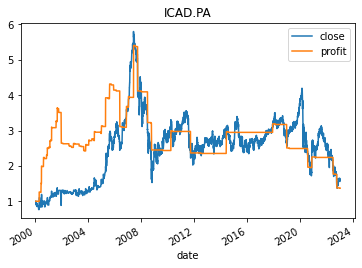

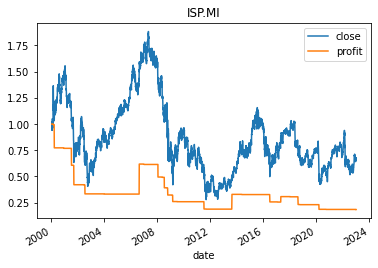

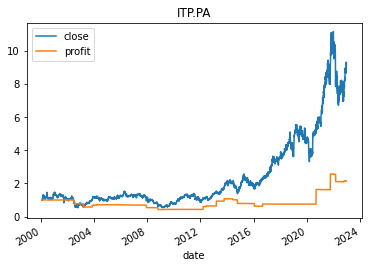

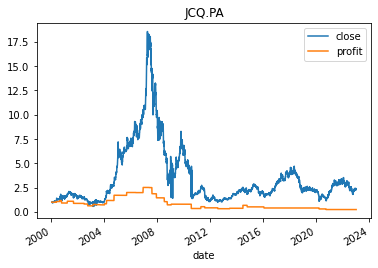

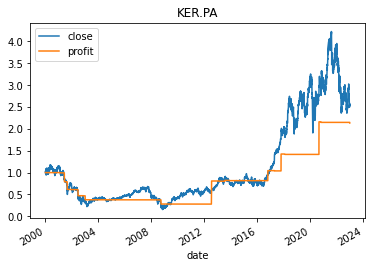

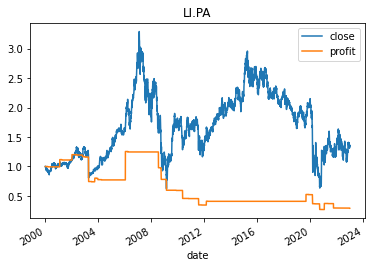

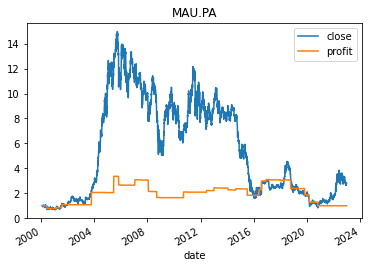

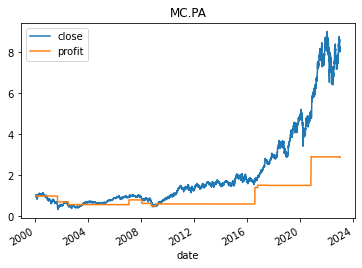

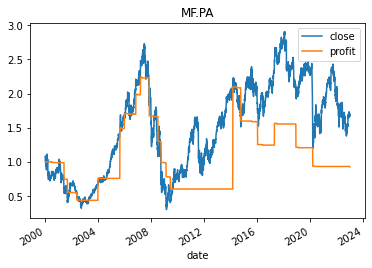

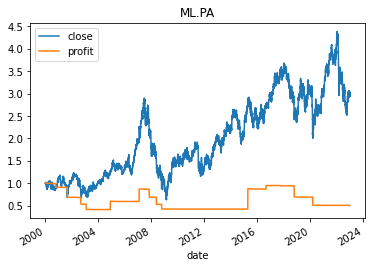

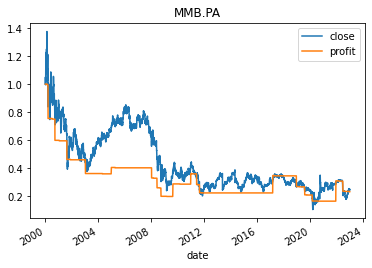

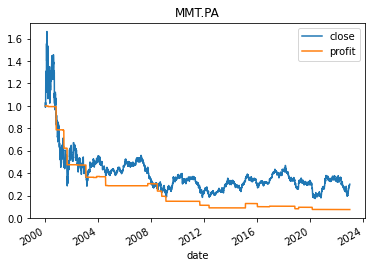

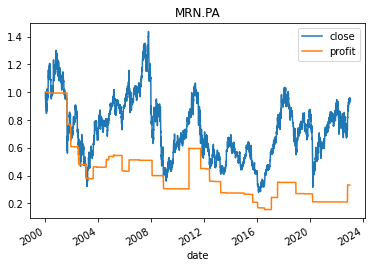

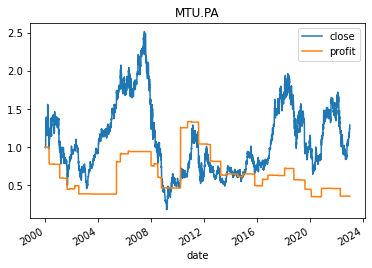

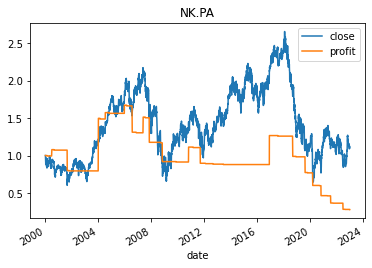

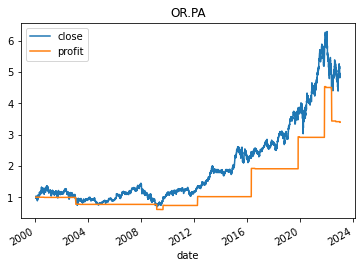

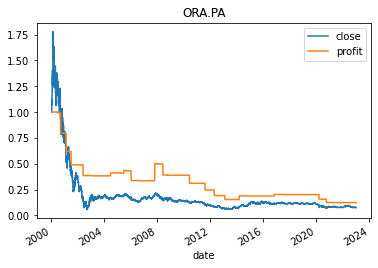

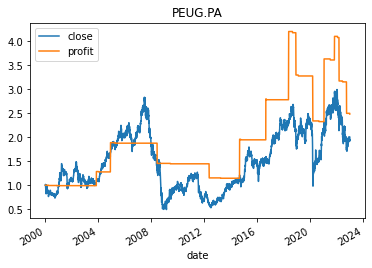

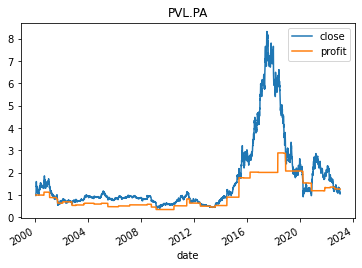

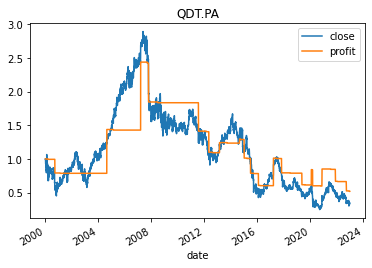

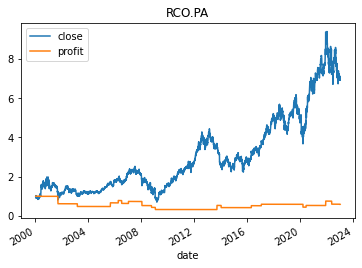

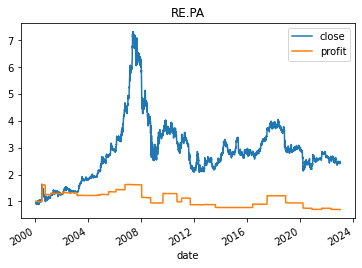

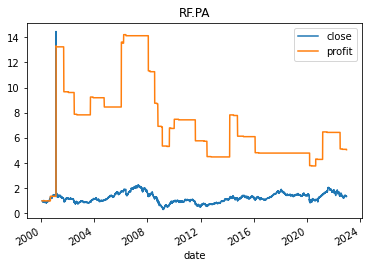

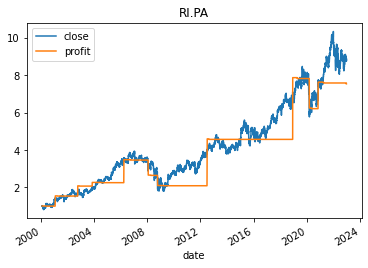

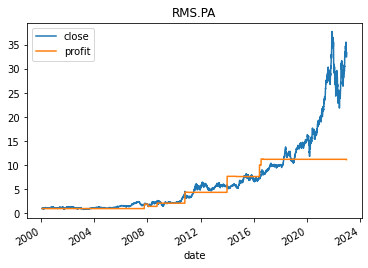

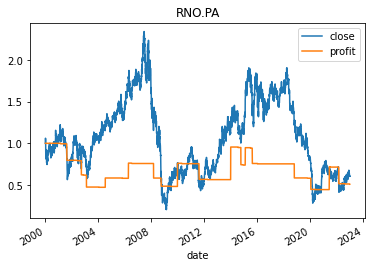

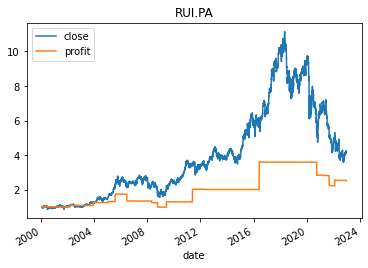

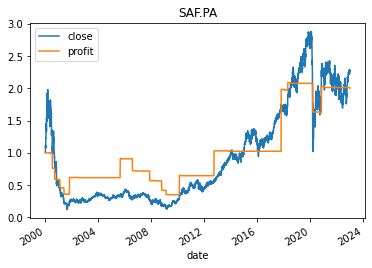

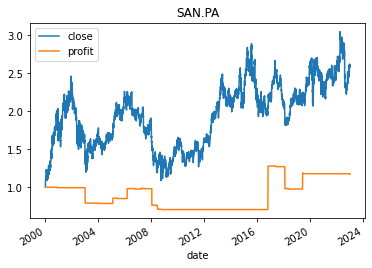

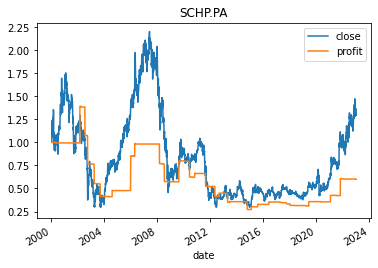

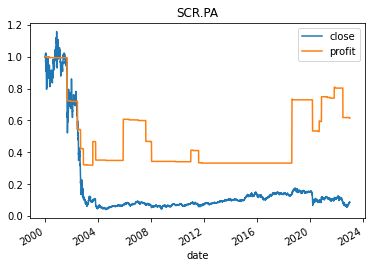

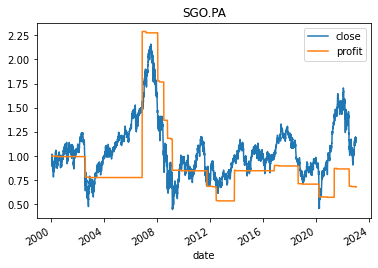

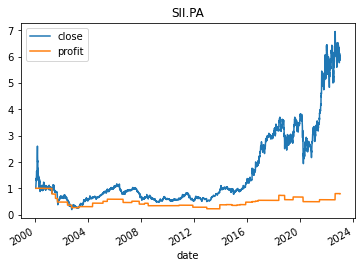

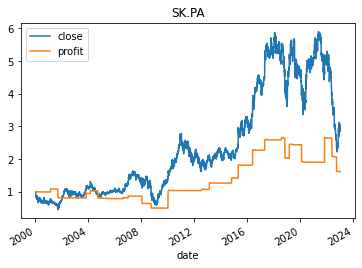

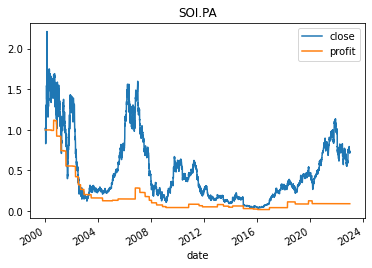

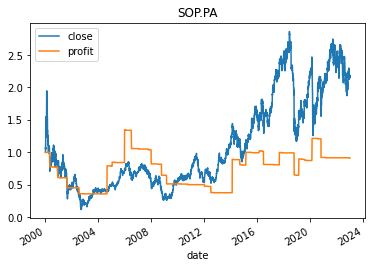

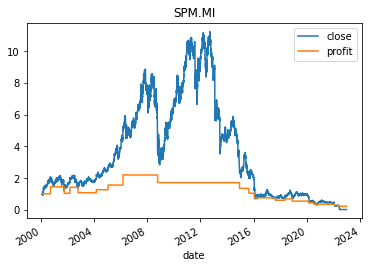

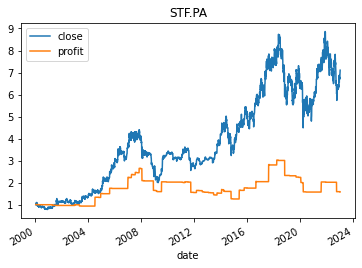

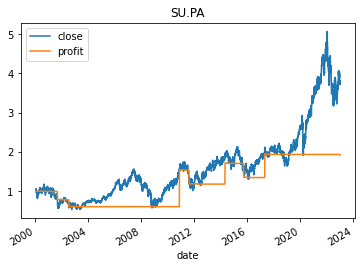

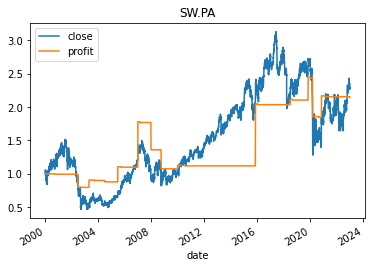

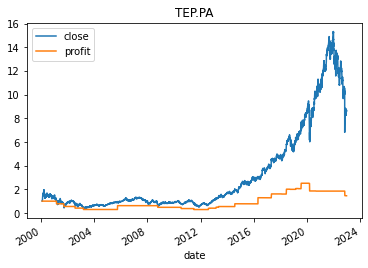

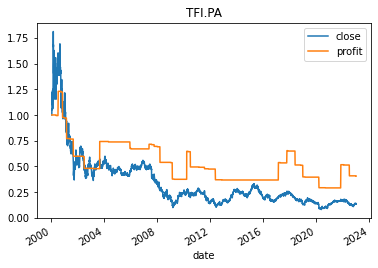

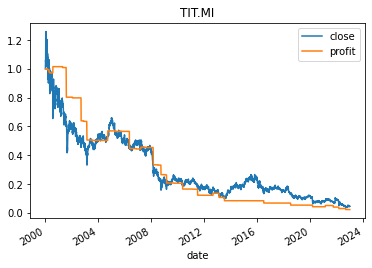

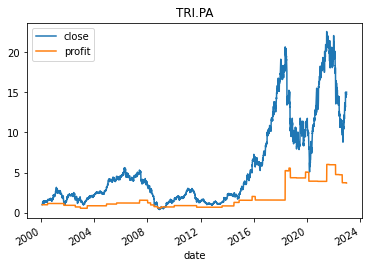

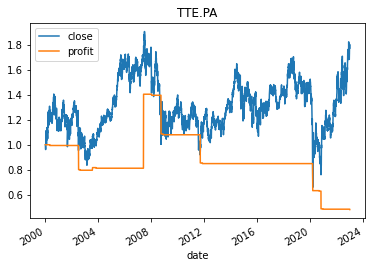

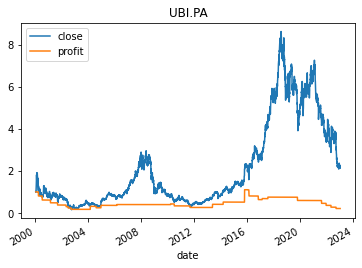

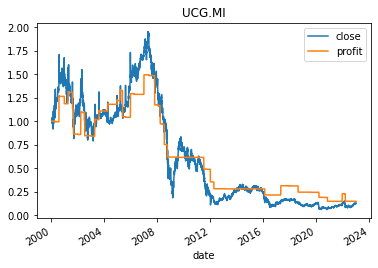

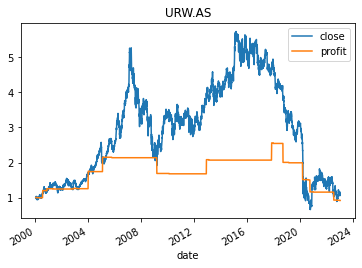

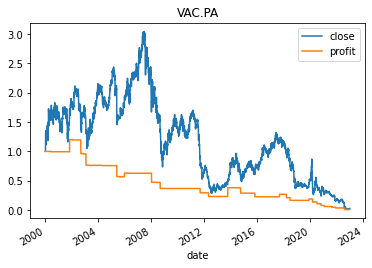

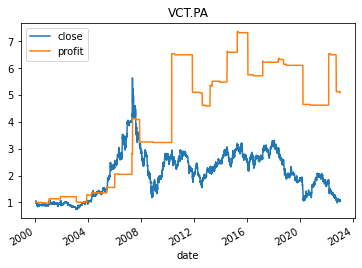

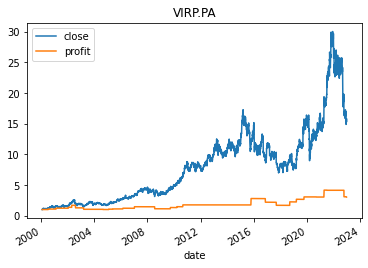

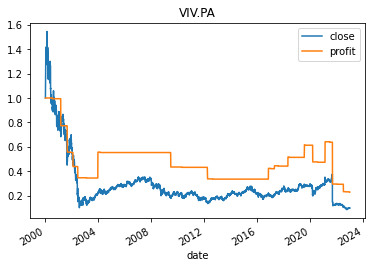

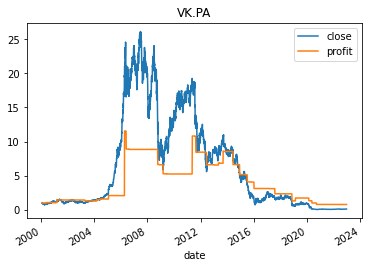

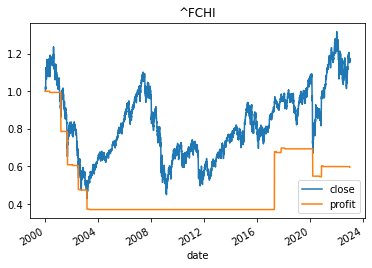

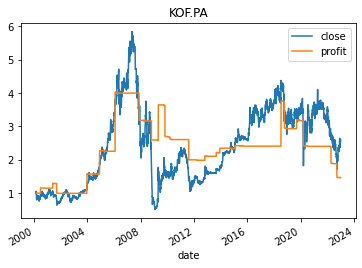

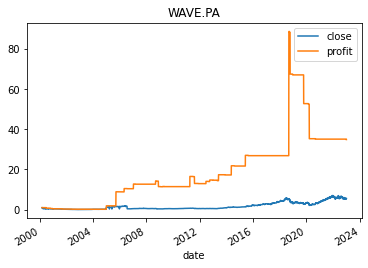

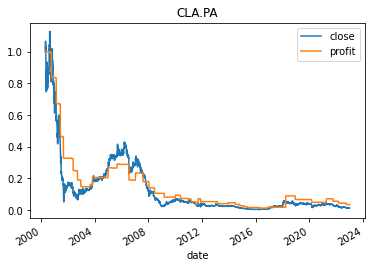

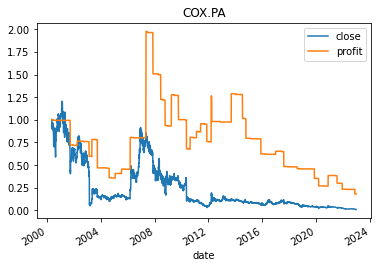

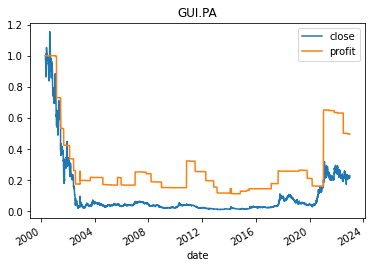

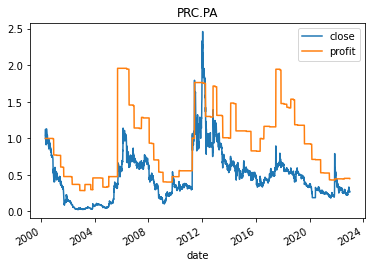

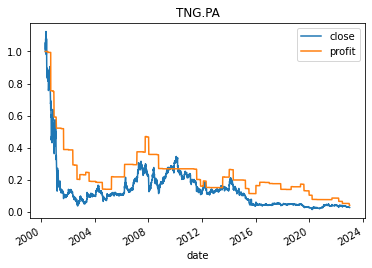

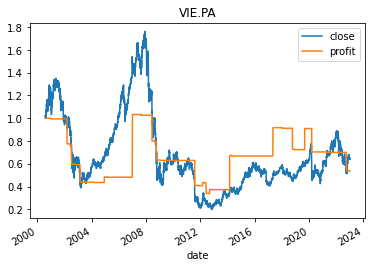

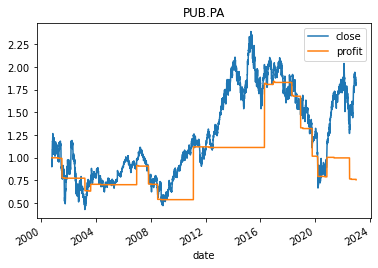

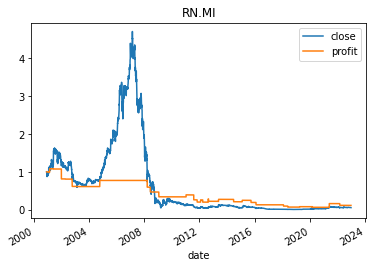

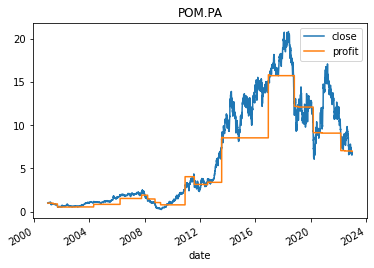

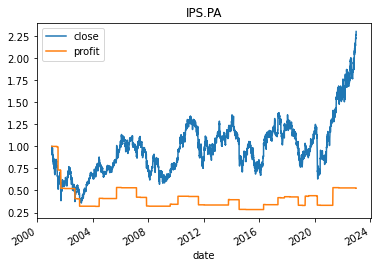

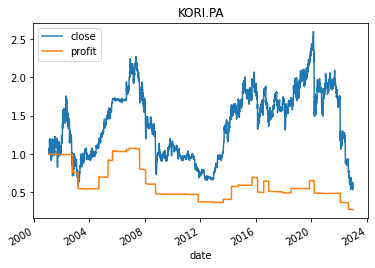

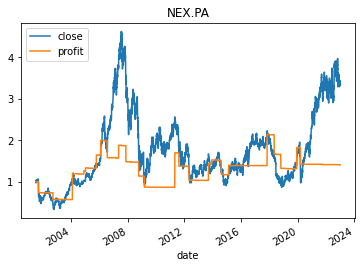

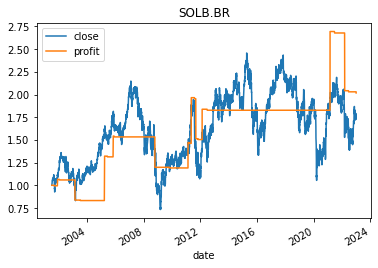

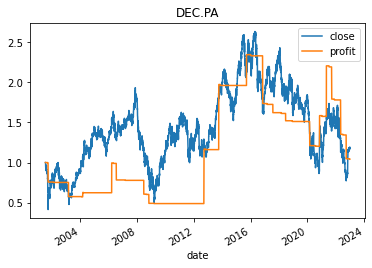

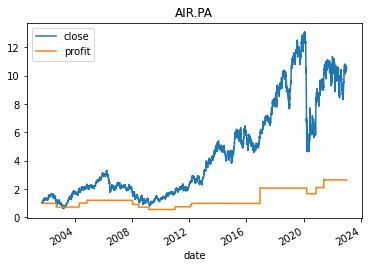

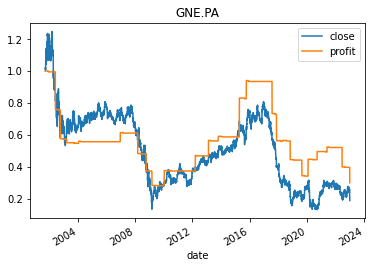

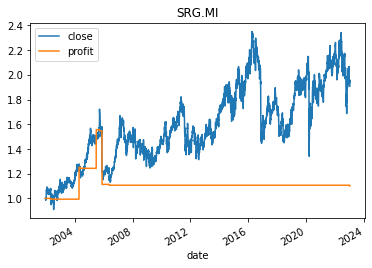

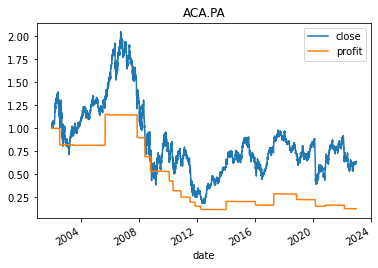

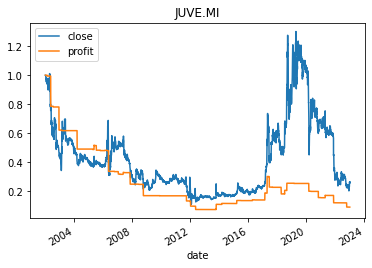

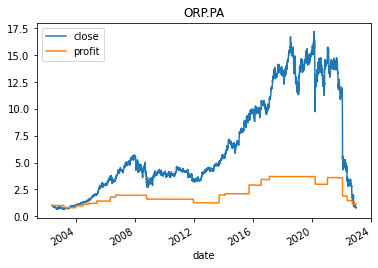

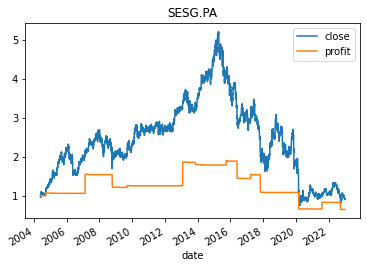

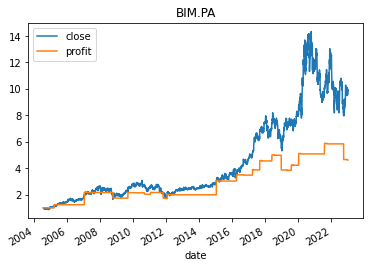

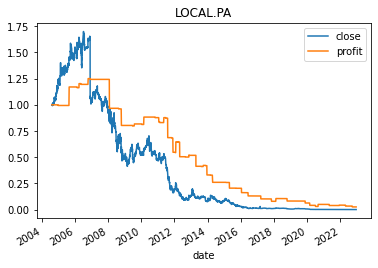

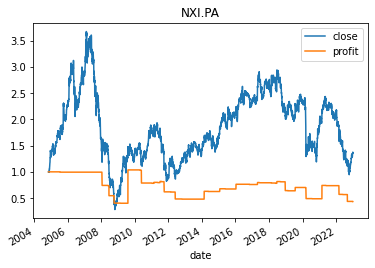

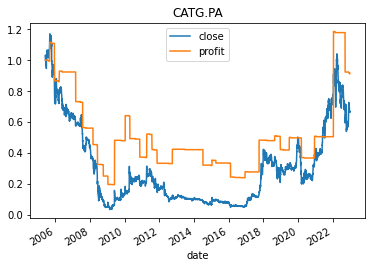

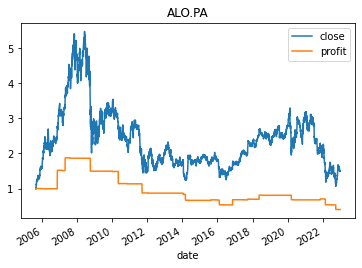

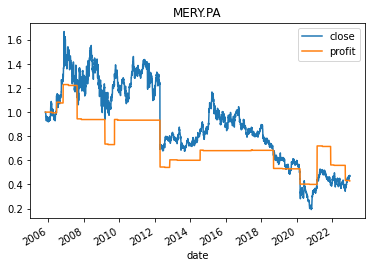

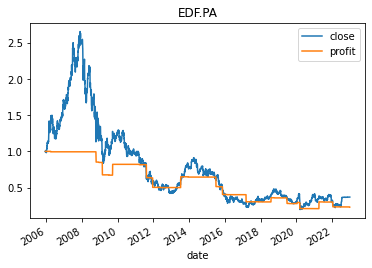

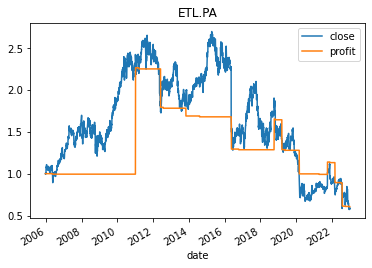

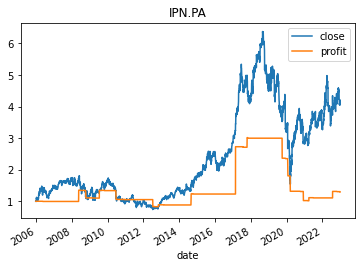

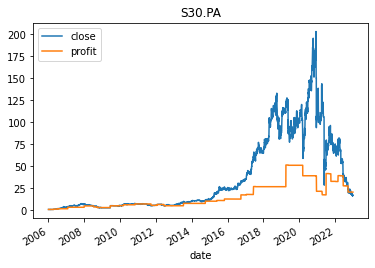

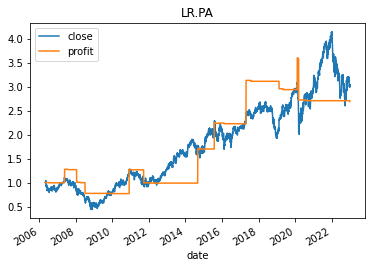

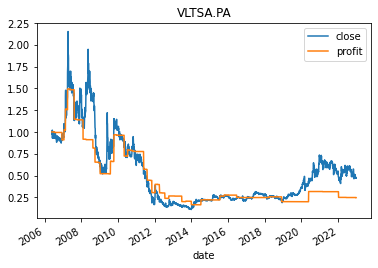

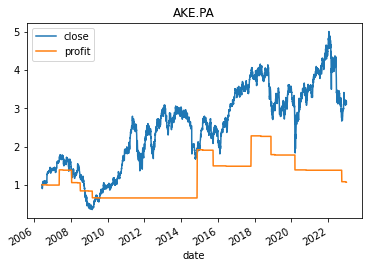

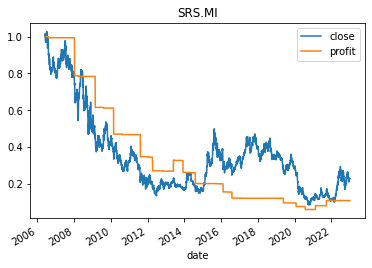

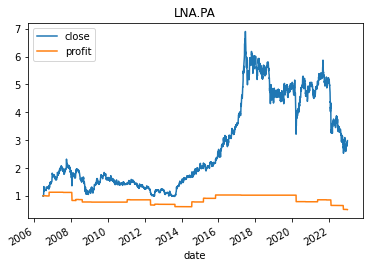

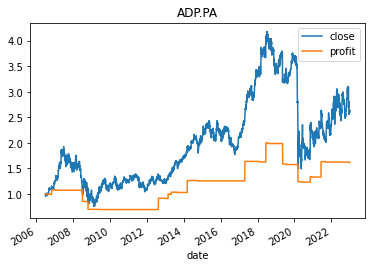

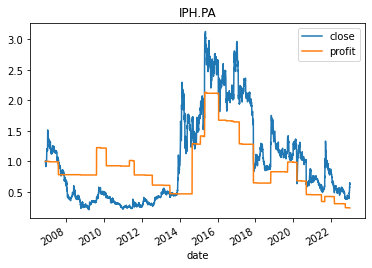

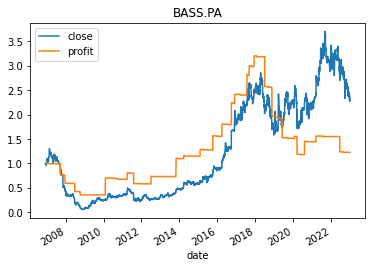

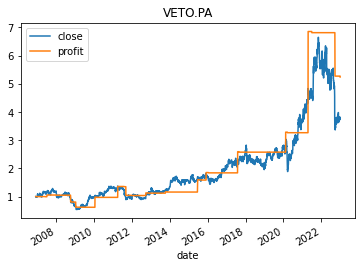

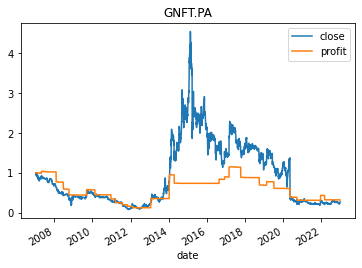

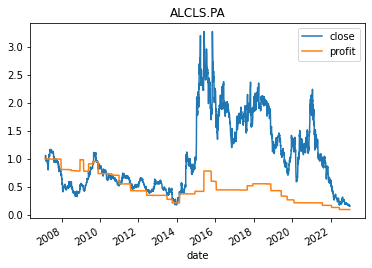

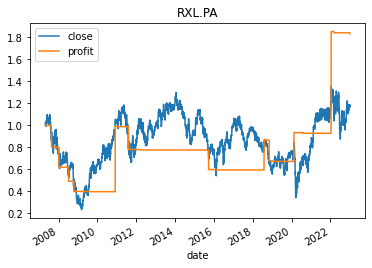

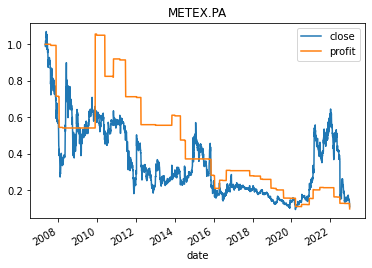

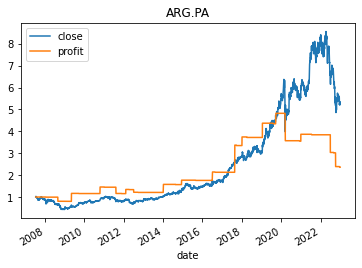

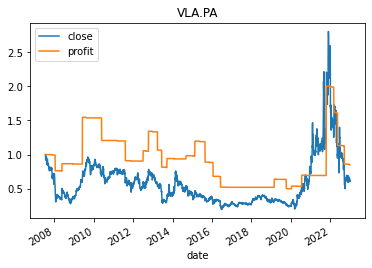

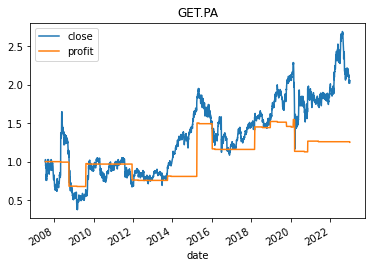

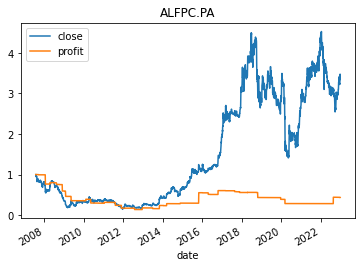

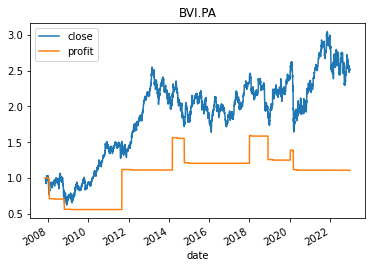

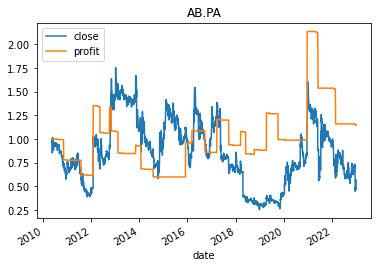

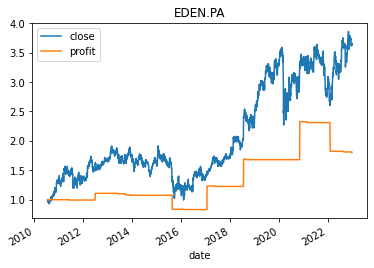

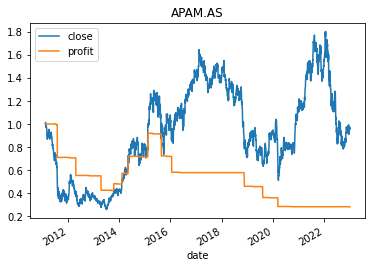

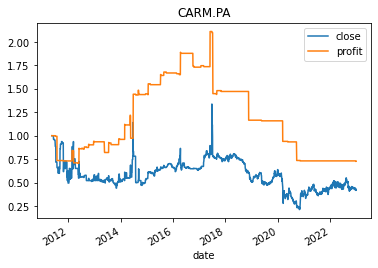

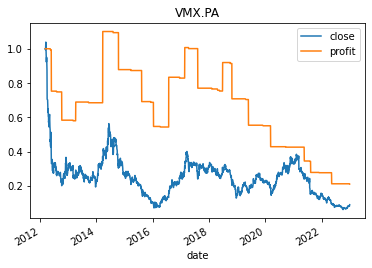

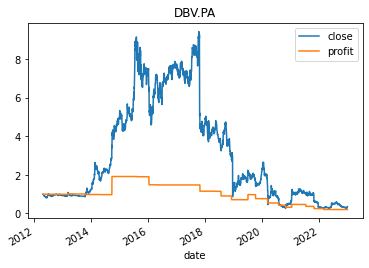

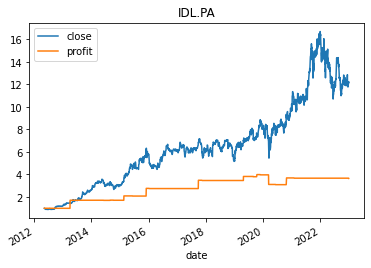

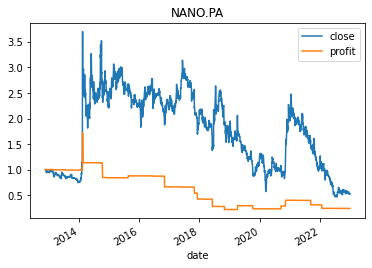

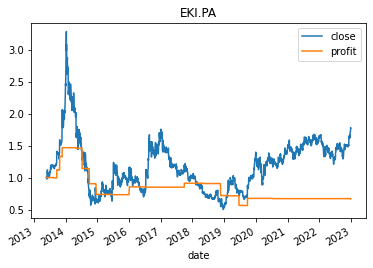

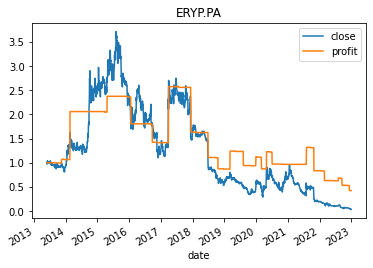

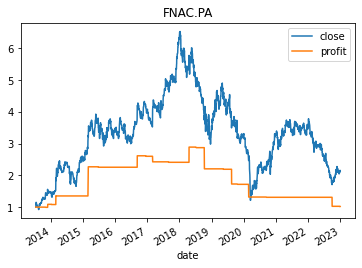

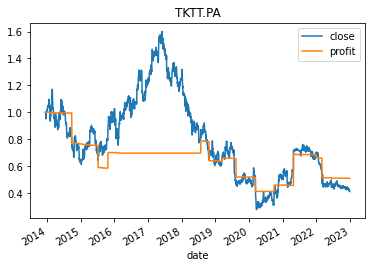

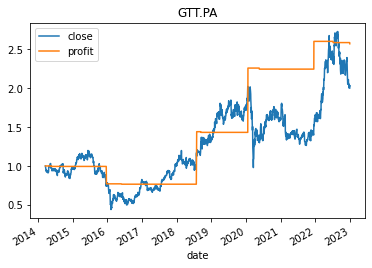

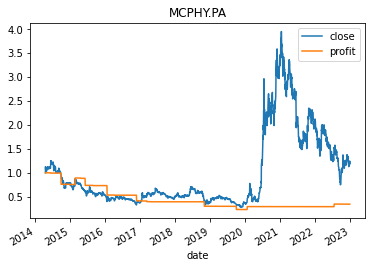

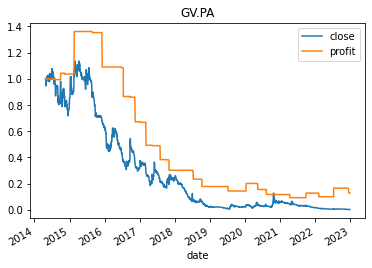

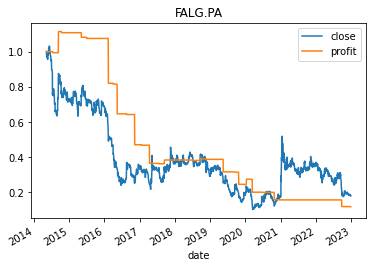

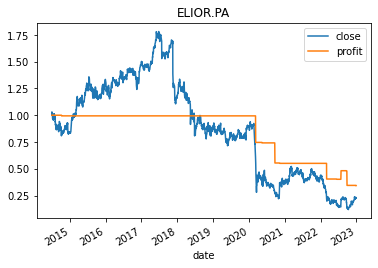

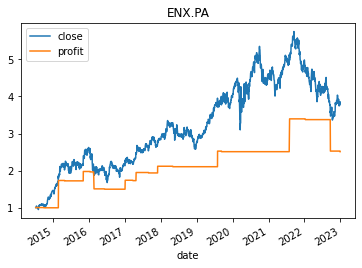

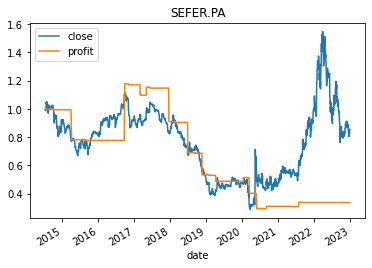

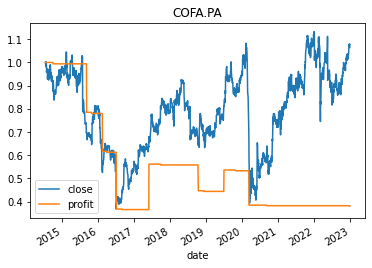

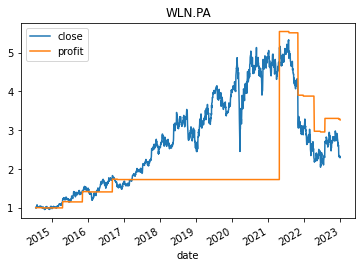

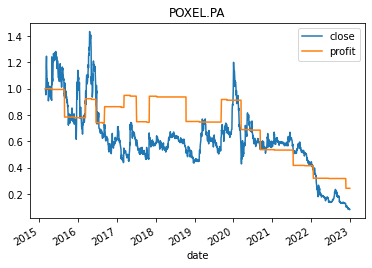

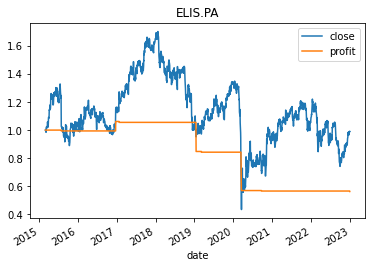

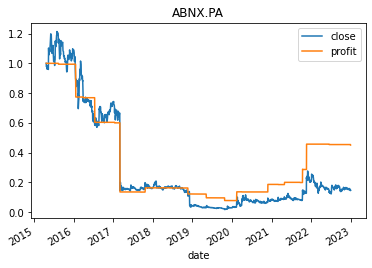

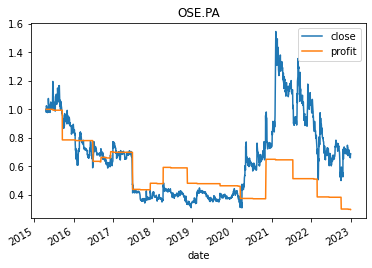

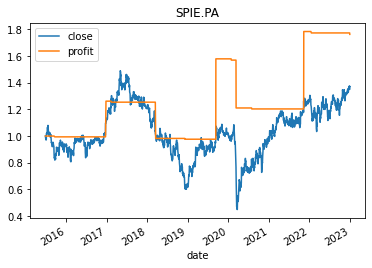

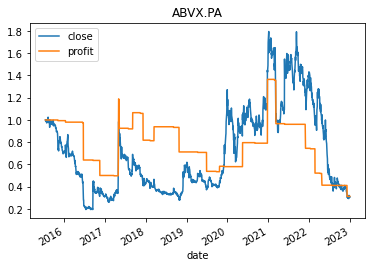

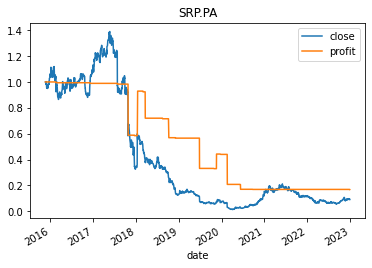

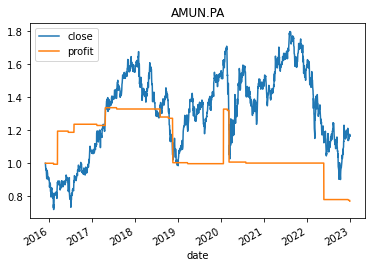

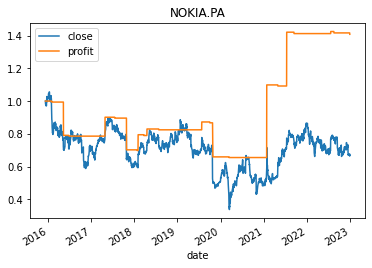

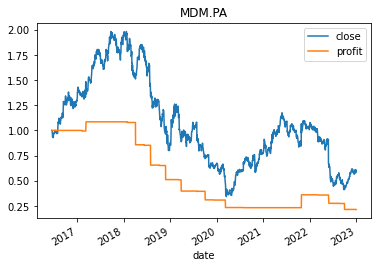

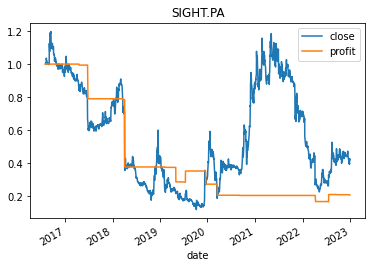

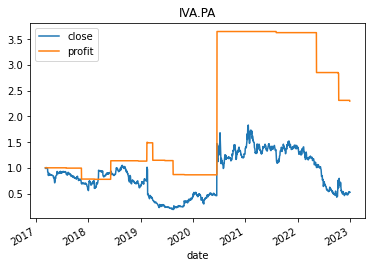

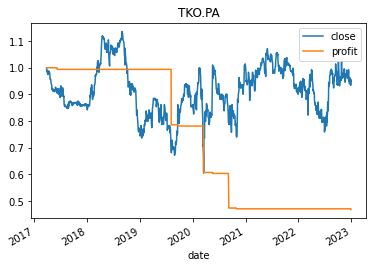

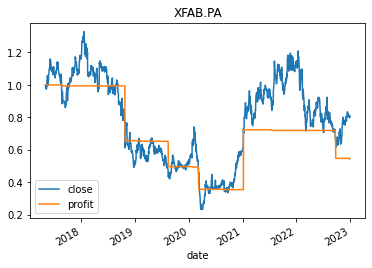

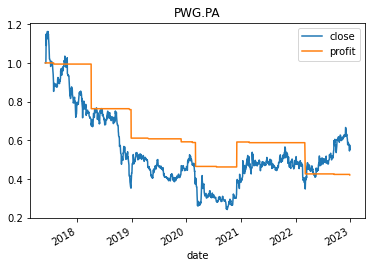

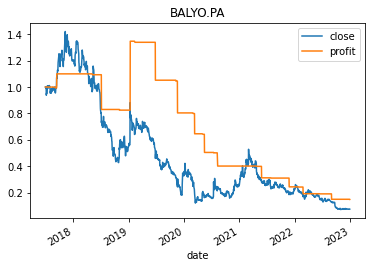

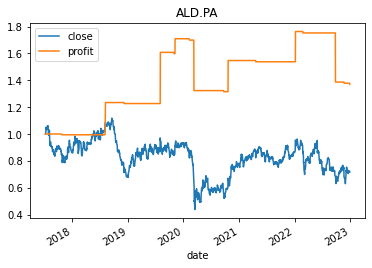

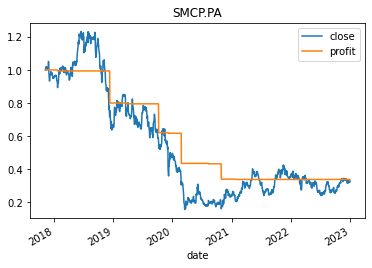

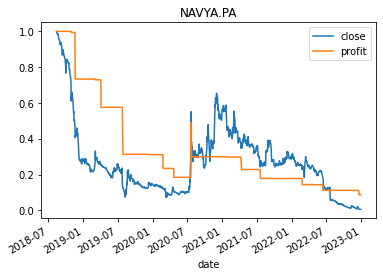

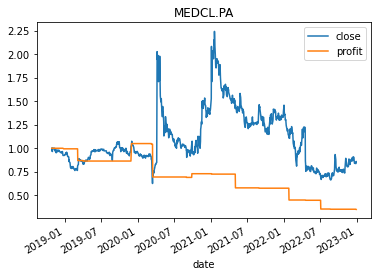

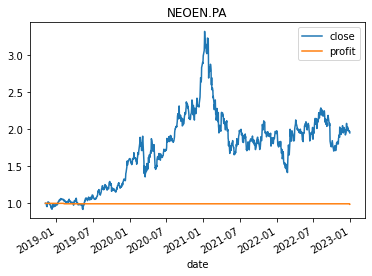

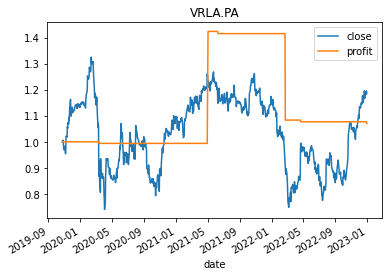

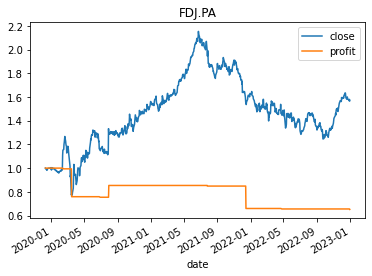

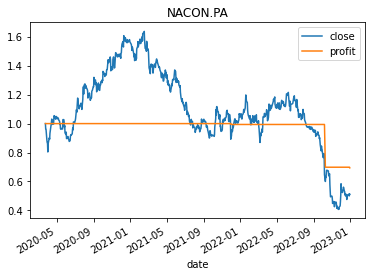

In [7]:
available_tickers = df['tic'].unique()

for ticker in available_tickers:
    profits = []

    ticker_df = df.loc[df['tic'] == ticker]
    ticker_df = add_supports_resistances(ticker_df)

    days = len(ticker_df)

    if days > 0:
        profit, bought_days, graph_df = get_profit(ticker_df)

        profits.append({
            'ticker': ticker,
            'profit': hf.pct(profit),
            'daily_profit': hf.pct(profit / bought_days) if bought_days > 0 else 0,
            'days': days,
            'bought_days': bought_days,
            'bought_days%': hf.pct(bought_days / days)
        })

    profit_df = pd.DataFrame(profits)

    # print(graph_df.head())
    graph_df.plot(title=ticker, x='date', y=['close', 'profit'])

    # print(f"Average profit: {profit_df['profit'].mean(skipna=True)}%")
    # print(f"Average daily profit %: {profit_df['daily_profit'].mean(skipna=True)}%")
    # print(f"Average bought days %: {profit_df['bought_days%'].mean(skipna=True)} days")


In [8]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(profit_df)

In [9]:
# cac_profit_df = profit_df[profit_df['ticker'].str.startswith('^FCHI')]
# print(cac_profit_df)
# print(f"Average profit: {cac_profit_df['profit'].mean(skipna=True)}%")
# print(f"Average daily profit %: {cac_profit_df['daily_profit'].mean(skipna=True)}%")
# print(f"Average bought days %: {cac_profit_df['bought_days%'].mean(skipna=True)} days")